In [1]:
import sys

import matplotlib
import numpy as np
import pandas as pd
import os
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from display_plot_utils import read_methods_results, results_base_path, methods, save_figure
from display_plot_utils import seeds, get_display_method_name, methods_order, color_palette
from display_plot_utils import get_masker_from_method_name, process_methods_names, process_methods_df
from display_plot_utils import plot_full_figure
from matplotlib import rcParams

matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rc('font', **{'size': 20})

%load_ext autoreload
%autoreload 2

# Figures

## Causal Inference experiments

###  IHDP dataset

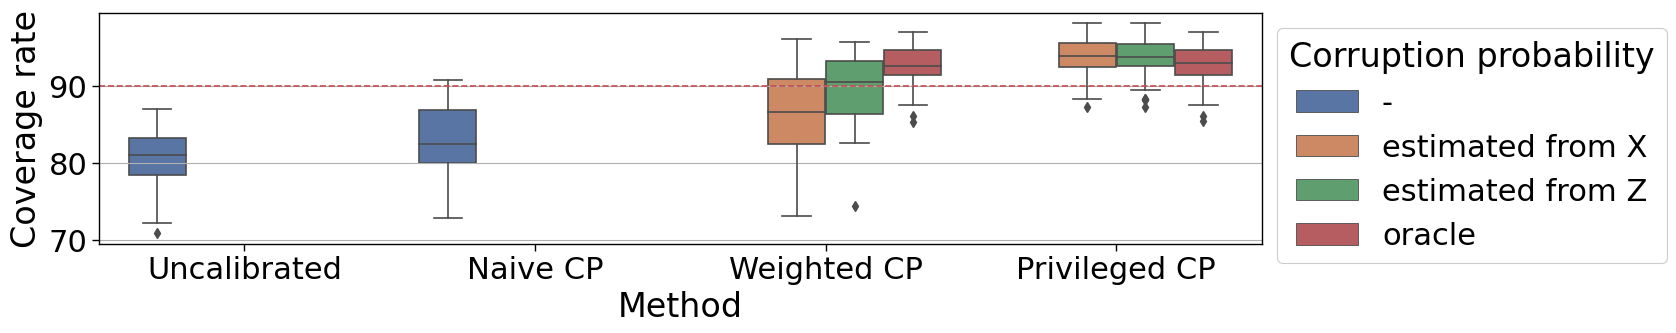

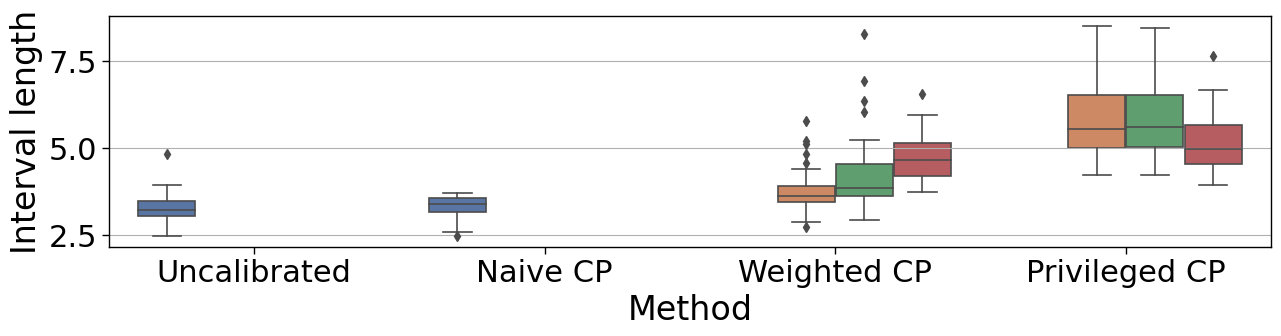

In [2]:
plot_full_figure("ihdp", "missing_y_ihdp", nominal_coverage_level=90,
                 methods_to_remove=['Naive CP\n(noisy+clean)'])

### Twins dataset

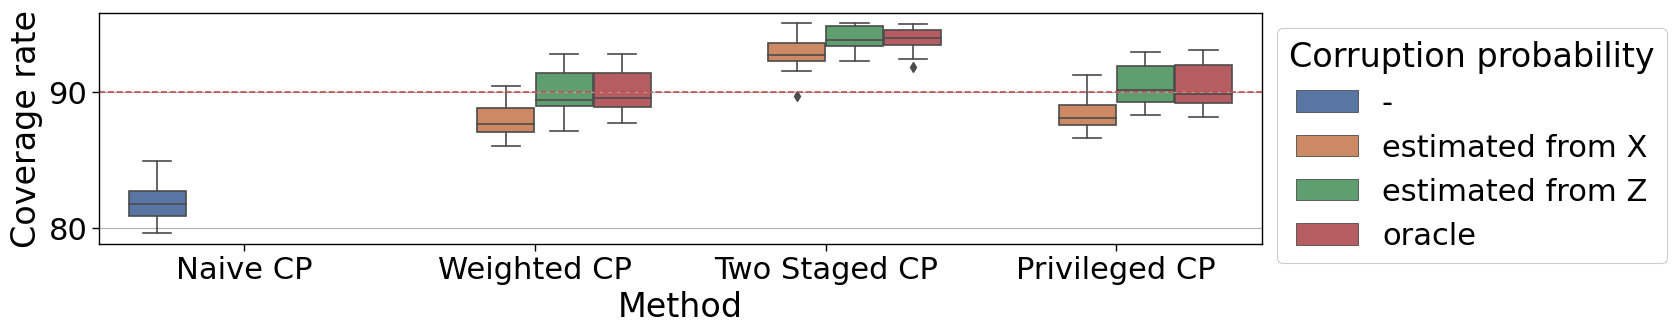

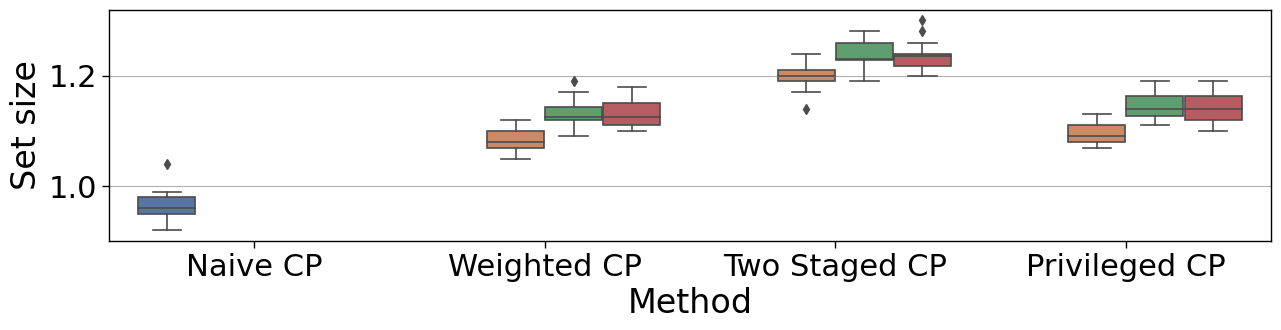

In [3]:
plot_full_figure("twins", "missing_y_twins", nominal_coverage_level=90, is_classification=True,
                methods_to_remove=['Naive CP\n(noisy+clean)'])

### NSLM dataset

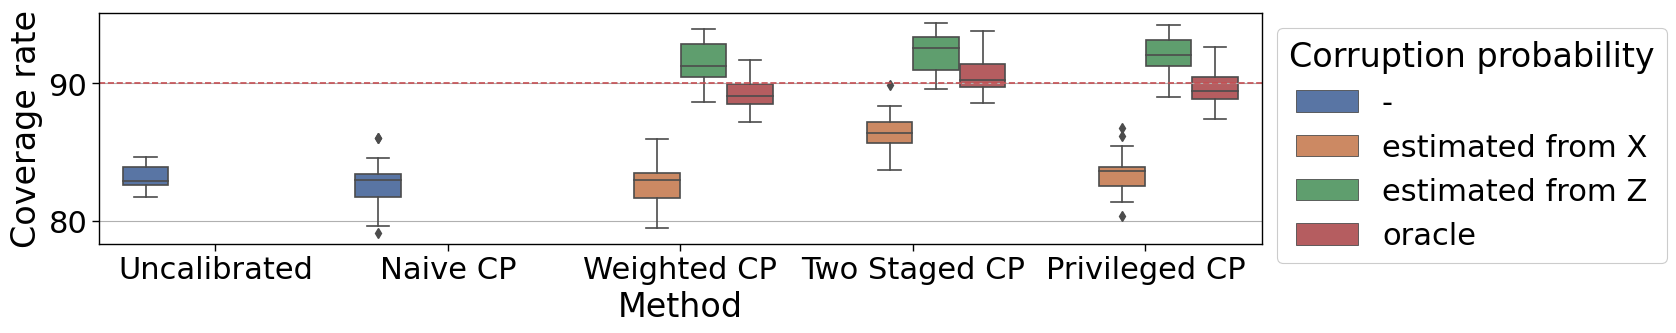

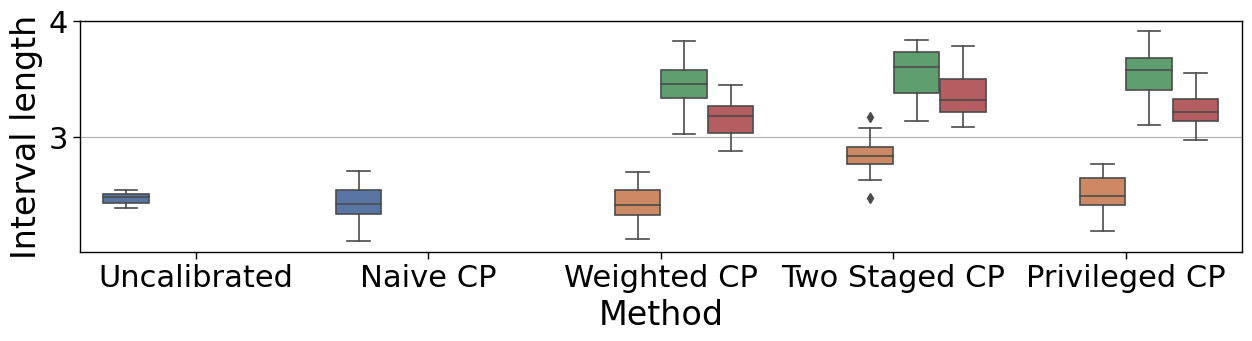

In [4]:
plot_full_figure("nslm", "missing_y_nslm", nominal_coverage_level=90,
                methods_to_remove=['Naive CP\n(noisy+clean)'])

## Noisy response experiments

### CIFAR-10N dataset

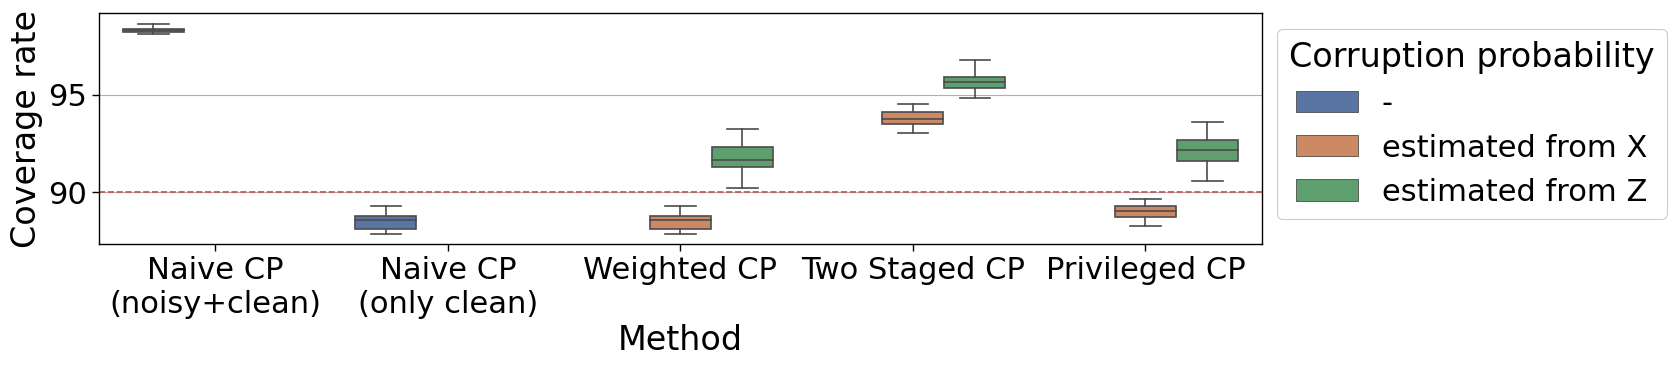

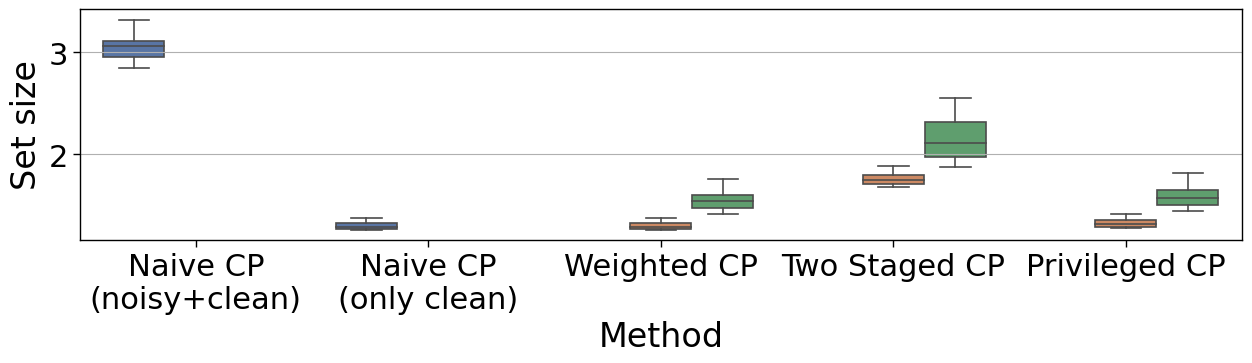

In [5]:
plot_full_figure("cifar10", "noised_y_cifar10", nominal_coverage_level=90, showfliers=False,
                is_classification=True)

### CIFAR-10C dataset - dispersive noise

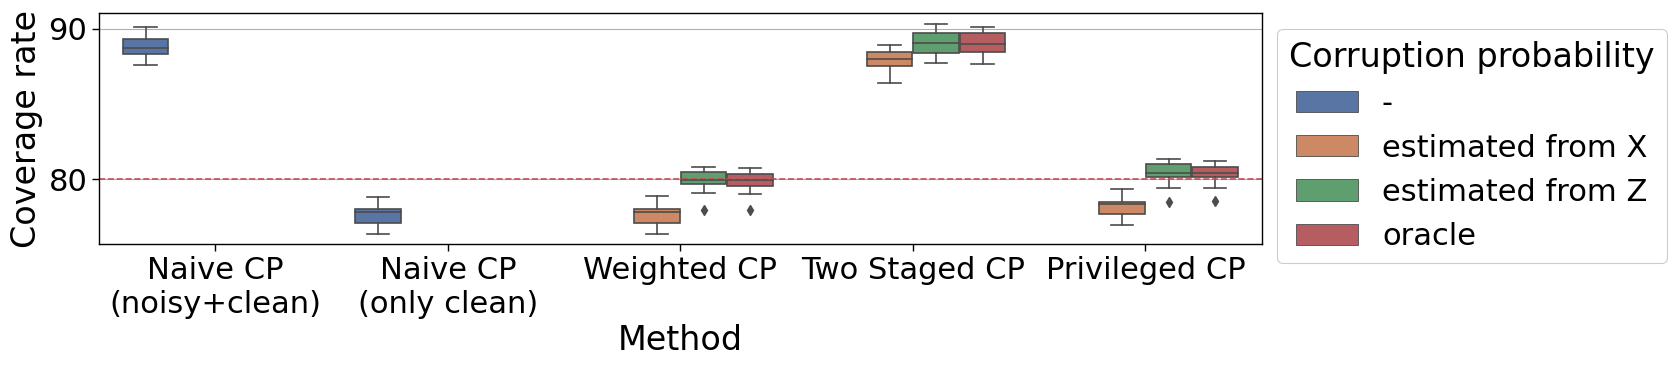

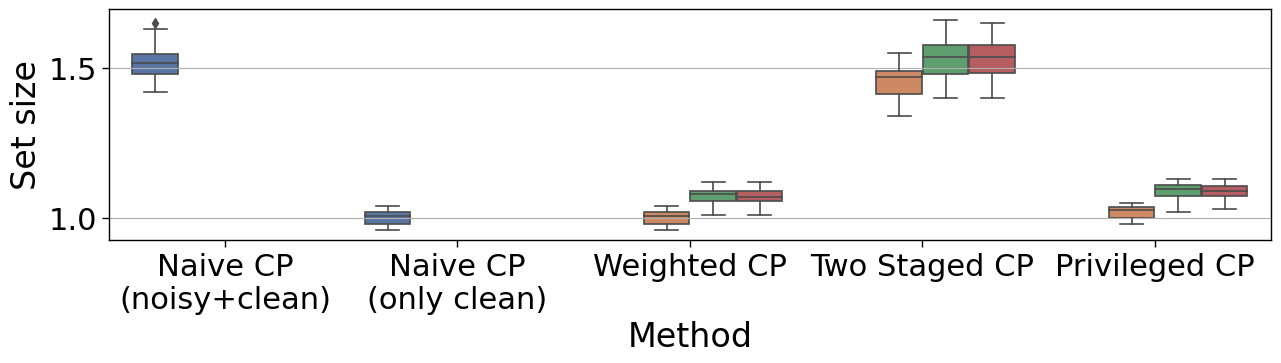

In [6]:
plot_full_figure("cifar10c", "noised_y_cifar10c", nominal_coverage_level=80,
                is_classification=True)

### CIFAR-10C dataset - adversarial noise

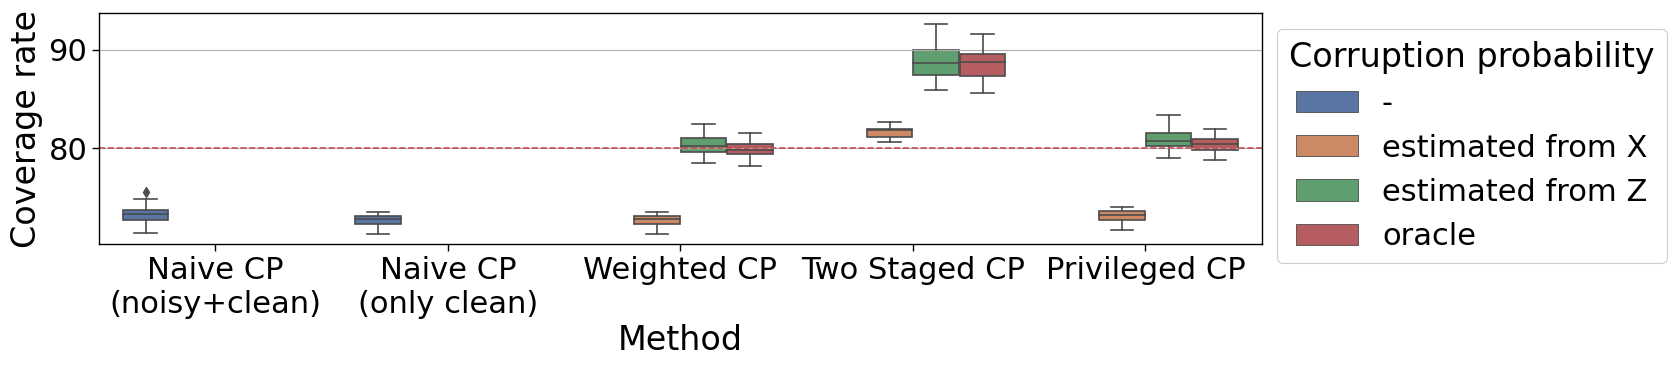

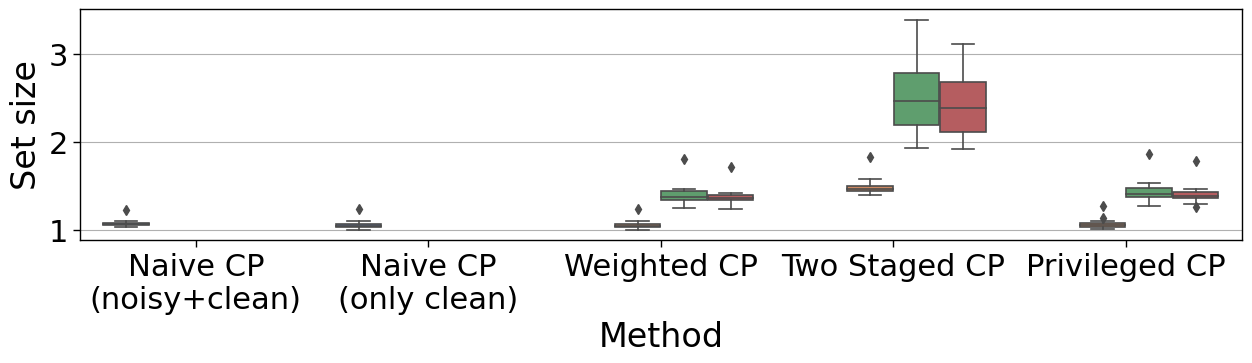

In [7]:
plot_full_figure("cifar10c_adversarial", "noised_y_cifar10c_adversarial", nominal_coverage_level=80,
                is_classification=True)

## Regression datasets experiments

corruption type: noised_y


array(['Uncalibrated', 'Naive CP', 'Naive WCP', 'Infeasible WCP',
       'Two Staged CP', 'Privileged CP'], dtype=object)

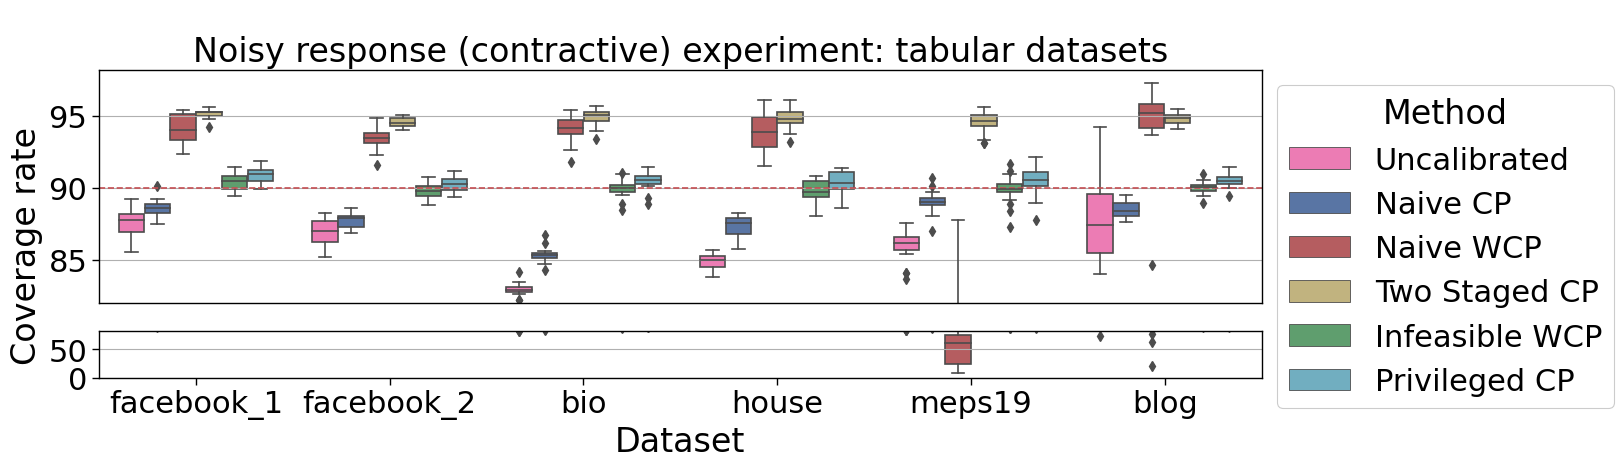

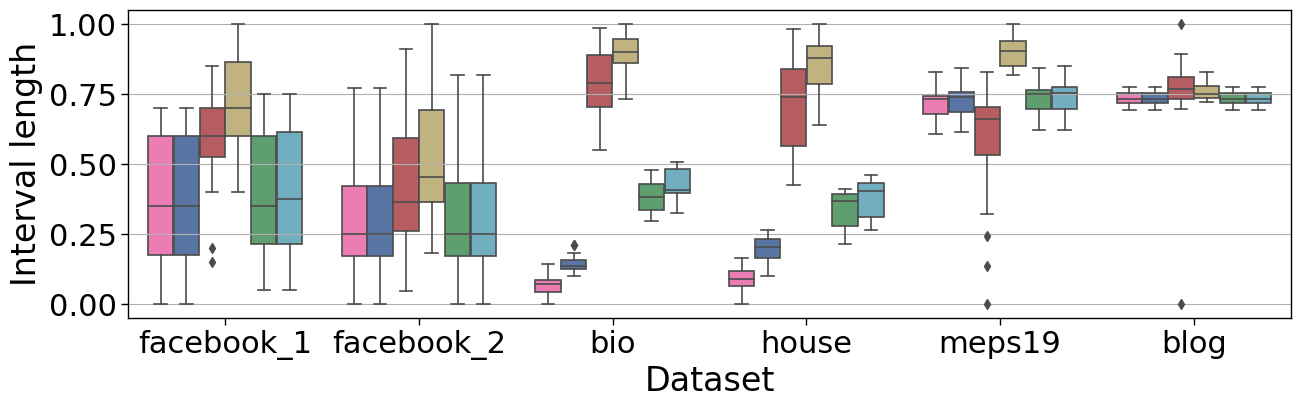

In [8]:
total_df = pd.DataFrame()
original_dataset_names = ['facebook_1', 'facebook_2', 'bio', 'house', 'meps_19', 'blog'] # 'blog' 'meps_19'
corruption_type = 'noised_y'
print(f"corruption type: {corruption_type}")

methods_to_keep = ['Uncalibrated', 'Naive', 'Two Staged oracle masker', 
                   'weighted network use z=False',
#                    'weighted xgb oracle masker',
                   'weighted oracle masker',
                   'PCP oracle masker']
methods_to_exclude = ['Naive CP (only clean)'] # ['nn errors', 'cvae errors', 'oracle',  'use z=true']
def keep_method(method_name):
    return any([a in method_name for a in methods_to_keep]) and not any([a in method_name for a in methods_to_exclude])

for dataset_name in [f"{corruption_type}_{d}" for d in original_dataset_names]:
    try:
        data_df = read_methods_results(results_base_path, dataset_name, methods, apply_mean=False, seeds=seeds)
        data_df = process_methods_df(data_df)
        data_df['Dataset'] = dataset_name.replace(f"{corruption_type}_", "").replace("meps_19", "meps19")
        data_df = data_df[data_df['Method'].apply(keep_method)]
        data_df['y2 length'] -= data_df['y2 length'].min()
        data_df['y2 length'] /= data_df['y2 length'].max()
        total_df = pd.concat([total_df, data_df])
    except Exception as e:
        print(f"data: {dataset_name}, error: {e}")

# display(total_df)

sns.set_theme(context='paper', style={
     'xtick.color': 'black',
     'ytick.color': 'black',
     'xtick.direction': 'out',
     'ytick.direction': 'out',
     'xtick.bottom': True,
     'xtick.top': False,
     'ytick.left': True,
     'ytick.right': False,
     'axes.facecolor': 'white',
     'axes.edgecolor': 'black',
     'axes.grid': True,
    }, 
    font_scale=2.5, rc={'figure.figsize':(15,4)})



# total_df['Method'] = total_df['Method'].apply(lambda x: x.replace("imputation", ""))
total_df['Method'] = total_df['Method'].apply(get_display_method_name)

# invert the grispec ratios
f, (ax1, ax2) = plt.subplots(nrows=2, sharex=True,
                             gridspec_kw={'height_ratios':[5, 1]}, figsize=(15,4))

# change the limits
curr_methods_order = [m for m in methods_order if m in total_df['Method'].unique()]
if corruption_type == 'missing_x':
    title_prefix = 'Missing features'
elif corruption_type == 'missing_y':
    title_prefix = 'Missing response'
elif corruption_type == 'noised_y':
    title_prefix = 'Noisy response (contractive)'
elif corruption_type == 'dispersive_noised_y':
    title_prefix = 'Noisy response (dispersive)'
elif corruption_type == 'noised_x':
    title_prefix = 'Noisy features'

ax1.set_title(f"{title_prefix} experiment: tabular datasets")
display(total_df['Method'].unique())
sns.boxplot(data=total_df, x='Dataset', y='full y2 coverage', hue='Method', ax=ax1, palette=color_palette,
           hue_order=curr_methods_order)
sns.boxplot(data=total_df, x='Dataset', y='full y2 coverage', hue='Method', ax=ax2, palette=color_palette,
           hue_order=curr_methods_order)

if corruption_type == 'noised_y':
    ax1.set_ylim(82, 98.2)
    ax2.set_ylim(0, 82)
elif corruption_type == 'dispersive_noised_y':
    ax1.set_ylim(78, 100)
    ax2.set_ylim(0, 78)
else:
    ax1.set_ylim(82, 98.2)
    ax2.set_ylim(0, 82)

ax1.set_ylabel("Coverage rate           ")
ax2.set_ylabel("")

# ax1.legend().remove()
ax2.legend().remove()

# ax1.spines['top'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
# ax2.xaxis.set_visible(False)
ax1.xaxis.set_visible(False)

sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax2.set_xlabel("Dataset")

ax1.axhline(y=90, color='r', linestyle='--')

# legend = plt.legend()
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((0, 0, 1, 0.1))
# plt.title(f'Corruption: {corruption_type.replace("_", " ")}')
# plt.ylim(83, 98.2)
# plt.ylabel("$Y$ coverage")
save_figure(corruption_type, "coverage.png")
plt.show()


sns.set_theme(context='paper', style={
     'xtick.color': 'black',
     'ytick.color': 'black',
     'xtick.direction': 'out',
     'ytick.direction': 'out',
     'xtick.bottom': True,
     'xtick.top': False,
     'ytick.left': True,
     'ytick.right': False,
     'axes.facecolor': 'white',
     'axes.edgecolor': 'black',
     'axes.grid': True,
    }, 
    font_scale=2.5, rc={'figure.figsize':(15,4)})



ax = sns.boxplot(data=total_df, x='Dataset', y='y2 length', hue='Method', palette=color_palette,
                hue_order=curr_methods_order)
plt.ylabel("Interval length")
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# legend = plt.legend()
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((0, 0, 1, 0.1))
plt.legend().remove()
# plt.ylim(top=1.)
# plt.title(f'Corruption: {corruption_type.replace("_", " ")}')
save_figure(corruption_type, "length.png")
plt.show()
